In [1]:
# !pip install torchsde
# !pip install torchdiffeq

import sys
sys.setrecursionlimit(10000) #colab/python complained about maximum recursion depth (RecursionError)

# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import os
import argparse
import time
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchsde

from functools import partial
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw

from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def get_batch(true_y, batch_time=10, batch_size=1):
    # true_y.shape = (data_size, batch_size, state_size)
    data_size = true_y.shape[0]
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    
def visualize_2d(true_y=None, pred_y=None, times=None, save=None, title='', xmin=-2., xmax=2., show=False):
    fig = plt.figure(figsize=(8,4))
    ax_traj = fig.add_subplot(1, 2, 1)
    ax_phase = fig.add_subplot(1, 2, 2)
    if title is not None:
        fig.suptitle(title)
        
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(times.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], times.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    if pred_y!=None:
        ax_traj.plot(times.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', times.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(xmin, xmax)
    ax_traj.legend(['Data E(t)', 'Data I(t)', 'NDE E(t)', 'NDE I(t)'])

    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    if pred_y!=None:
        ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(xmin, xmax)
    ax_phase.set_ylim(xmin, xmax)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    if show == True:
        plt.show()

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [33]:
class ODEFunc(nn.Module):

    def __init__(self, input_size, hidden_size=32):
        super(ODEFunc, self).__init__()
        

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(), #try relu?
            nn.Linear(hidden_size, input_size),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y) #why would it be better to let it get recurrent?
        # return self.net(y)
        

class fcRNN(nn.Module): 
    #latent RNN 
    #see for possible ODE-RNN implementation: https://proceedings.neurips.cc/paper/2019/file/42a6845a557bef704ad8ac9cb4461d43-Paper.pdf
    def __init__(self, input_size, hidden_dim, output_size, n_layers):
        super(fcRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, 
                          hidden_dim, n_layers, 
                          nonlinearity='relu',
                          batch_first=True) # RNN hidden units
        self.fc = nn.Linear(hidden_dim, output_size) # output layer
        
    def forward(self, x):
        batch_size, _, _ = x.shape
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).requires_grad_().to(device)
        out, hidden = self.rnn(x, h0.detach())
        out = out.view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)
        return out[:, -1, :]


from typing import Sequence

class SDE(object):
    """Stochastic harmonic oscillator
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (1., 1.), b: Sequence = (.0, .0)):
        super().__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        a1, a2 = self.a

        f1 = a1 * x2
        f2 = -a1 * a2**2 * x1 
        return torch.cat([f1, f2], dim=1)

    def g(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        b1, b2 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        return torch.cat([g1, g2], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs

def model_predict(pred_len, model, initial_condition):
    test_inputs = initial_condition
    pred_traj = []
    for i in range(train_window):
        pred_traj.append(test_inputs[i])

    with torch.no_grad():
        for i in range(pred_len):
            seq = torch.tensor(np.array(pred_traj).squeeze()[-train_window:])
            model_out = model(seq.unsqueeze(0)).squeeze().detach().numpy().reshape(-1)
            pred_traj.append(model_out)
    pred_traj = np.array(pred_traj)
    return pred_traj

In [34]:
import itertools

#2D ex: Wilson-Cowan (stable limit cycle and unstable fixed point)
class wilsoncowan_SDE(object):
    """Stochastic harmonic oscillator
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, w: Sequence = (16., 16., -12., -4.), p: Sequence = (-1., -4.), r: Sequence = (.0), sigma: Sequence = (.0, .0)):
        super().__init__()
        self.w = w
        self.p = p
        self.r = r
        self.sigma = sigma

    def f(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        w11, w12, w21, w22 = self.w
        p1, p2 = self.p
        r = self.r

        f1 = -x1 + (1-r*x1)*torch.sigmoid(w11*x1+w21*x2 + p1)
        f2 = -x2 + (1-r*x2)*torch.sigmoid(w12*x1+w22*x2 + p2)
        return torch.cat([f1, f2], dim=1)

    def g(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        sigma1, sigma2 = self.sigma

        g1 = x1 * sigma1
        g2 = x2 * sigma2
        return torch.cat([g1, g2], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs
    
def make_grid(dim, low, high, delta):
    "makes grid in dim dimensions with evenly spaced (hyper)cubes"
    n=int((high-low)/delta)+1 #+1?

    grid = []
    for coords in itertools.product(range(n),repeat=dim):
        gc = []
        for i in coords:
            gc.append(low+i*delta)
        grid.append(gc)
    return grid

def create_inout_sequences(input_data, tw):
    train_data = []
    labels = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_data.append(torch.FloatTensor(train_seq.detach().cpu()).squeeze(1).unsqueeze(0))
        labels.append(torch.FloatTensor(train_label.detach().cpu()).squeeze(1).unsqueeze(0))

    return torch.cat(train_data, 0), torch.cat(labels, 0)

def create_batchio_sequences(ys, train_window=10):
    batch_size = ys.shape[1]
    input_size = ys.shape[2]
    data_train_r = torch.empty((0,train_window,input_size))
    labels_r = torch.empty((0,1,input_size))
    for i in range(batch_size):
        data_train_i, labels_i = create_inout_sequences(ys[:,i,:], train_window)
        # print(data_train_i.shape)
        data_train_r = torch.cat((data_train_r, data_train_i))
        labels_r = torch.cat((labels_r, labels_i))
    return data_train_r, labels_r

In [26]:
#2D example: stochastic stable orbit
system = "stoch_wc" #SHO ? stoch_harm_osc
# batch_size, state_size, brownian_size = 8, 2, 2
state_size = 2
t_len = 1000
device = 'cpu'

nsteps = 100

t = torch.linspace(0., 25., t_len).to(device)

sigma = 0.
sde = wilsoncowan_SDE()
# y0 = torch.full((batch_size, state_size), .5)
y0 = torch.tensor(make_grid(state_size, .05, 1., .3)) #grid
batch_size = y0.shape[0] #batch size = numer of point on grid
ys = torchsde.sdeint(sde, y0, t)

In [6]:
true_y = ys
true_y0 = y0

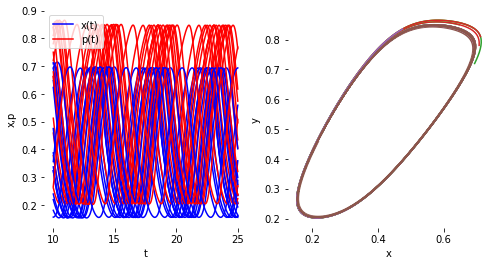

In [7]:
folder_name = "figures/wilsoncowan/shortened/"
makedirs(folder_name)

fig = plt.figure(figsize=(8, 4), facecolor='white')
ax_traj = fig.add_subplot(121, frameon=False)
ax_phase = fig.add_subplot(122, frameon=False)
time_shift = 400

for i in range(batch_size):
    ax_traj.plot(t.detach().numpy()[time_shift:], true_y[time_shift:,i,0].detach().numpy(), c='b')
    ax_traj.plot(t.detach().numpy()[time_shift:], true_y[time_shift:,i,1].detach().numpy(), c='r')
    ax_phase.plot(true_y[time_shift:,i,0].detach().numpy(), true_y[time_shift:,i,1].detach().numpy())
    
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,p')
ax_traj.legend(['x(t)', 'p(t)'])
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
plt.savefig(folder_name+"/data.png")

In [8]:
#use as data only limit cycle orbits
# true_y = ys[time_shift:,:,:]
# t = t[time_shift:]
# visualize_2d(true_y, None, t, None, title="", save="")

In [9]:
niters = 200
test_freq = 50
hidden_size = 100

size_folder_name = folder_name+"/N%s/"%hidden_size
makedirs(size_folder_name)
learning_folder_name =folder_name+"/N%s/"%hidden_size+"/learning"
makedirs(learning_folder_name)

#initialize NODE
input_size = true_y.cpu().detach().numpy().shape[-1]
func = ODEFunc(input_size=input_size, hidden_size=hidden_size)#.to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

In [11]:
xmin = np.min(true_y.cpu().detach().numpy())
xmax = np.max(true_y.cpu().detach().numpy())
ii = 0
end = time.time()
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
for itr in tqdm(range(1, niters + 1)):
    # if itr % 2000 == 0: #adjust learning parameter
    #     optimizer.param_groups[0]['lr'] *= .5
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(true_y, batch_time=10, batch_size=16)
    pred_y = odeint(func, batch_y0, batch_t)#.to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        save_name = learning_folder_name +"/learning_T%s"%itr
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            # loss = torch.mean(torch.abs(pred_y - batch_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

            visualize_2d(true_y, pred_y, t, title="Training step %s"%itr, save=save_name, xmin=xmin, xmax=xmax)
            plt.close()
            ii += 1

    end = time.time()

  0%|          | 0/200 [00:00<?, ?it/s]

Iter 0050 | Total Loss 0.014255
Iter 0100 | Total Loss 0.006972
Iter 0150 | Total Loss 0.007427
Iter 0200 | Total Loss 0.011720


In [23]:
batch_y0.shape, batch_t.shape

(torch.Size([16, 16, 2]), torch.Size([10]))

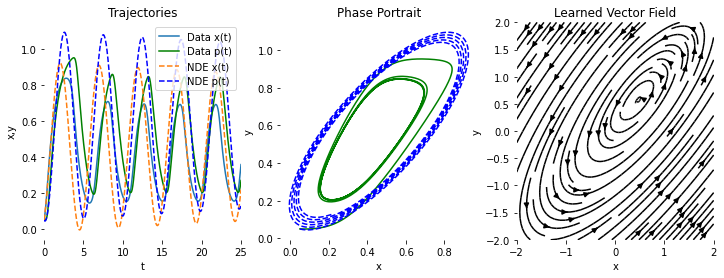

In [12]:
pred_y = odeint(func, y0.to(device), t.to(device)).to(device)
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)

ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
# ax_traj.set_ylim(-2, 2)
ax_traj.legend(['Data x(t)', 'Data p(t)', 'NDE x(t)', 'NDE p(t)'])

ax_phase.cla()
ax_phase.set_title('Phase Portrait')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
# ax_phase.set_xlim(-2, 2)
# ax_phase.set_ylim(-2, 2)

ax_vecfield.cla()
ax_vecfield.set_title('Learned Vector Field')
ax_vecfield.set_xlabel('x')
ax_vecfield.set_ylabel('y')
y, x = np.mgrid[-2:2:21j, -2:2:21j]
dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = (dydt / mag)
dydt = dydt.reshape(21, 21, 2)

ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
# ax_vecfield.set_xlim(-2, 2)
# ax_vecfield.set_ylim(-2, 2)
plt.savefig(size_folder_name + "/behavior_N%s.png"%hidden_size)

In [35]:
#learning with latent RNN
hidden_size = 100
learning_folder_name = folder_name+"/N%s/"%hidden_size+"/Flearning/"
makedirs(learning_folder_name)

feature_size = true_y.shape[2]
model = fcRNN(feature_size, hidden_size, feature_size, 2).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Model has a total of {0} parameters.".format(pytorch_total_params))

Model has a total of 30802 parameters.


In [36]:
train_window = 10
# generating training data and labels for RNN from grid batch
data_train_r, labels_r = create_batchio_sequences(ys, train_window)
data_train_r[:,0,:].shape
t.shape

torch.Size([1000])

In [46]:
pred_len = true_y.shape[0]-train_window
epochs = 10
test_freq = 50
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ii = 0
for itr in tqdm(range(epochs)):
    # if itr > 2000:
    #     optimizer.param_groups[0]['lr'] = 1e-3
    optimizer.zero_grad()
    y_pred = model(data_train_r)
    # y_pred = odeint(model, data_train_r[:,:,:], t[:10])#.to(device)
    loss = loss_function(y_pred, labels_r.squeeze())
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
    if itr % test_freq == 0:
        print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.8f}')
        test_inputs = data_train_r[0].squeeze().detach().numpy()
        pred_traj = model_predict(pred_len, model, test_inputs)
        save_name = learning_folder_name +"/learning_T%s"%itr
        visualize_2d(true_y, torch.tensor(pred_traj).unsqueeze(1), t, title="Training step %s"%itr, save=save_name, xmin=0., xmax=1.)
        plt.close()
        ii += 1

print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.10f}')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  99 loss: 0.0000025650


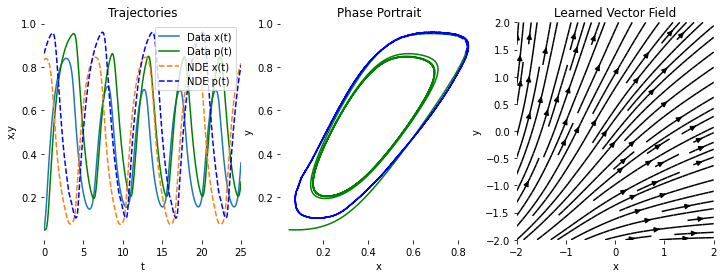

In [47]:
test_inputs = data_train_r[100].squeeze().detach().numpy()
pred_traj = model_predict(t.shape[0]-train_window, model, test_inputs)
pred_y = torch.tensor(pred_traj).unsqueeze(1) #odeint(func, y0.to(device), t.to(device)).to(device)
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)

ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
# ax_traj.set_ylim(-2, 2)
ax_traj.legend(['Data x(t)', 'Data p(t)', 'NDE x(t)', 'NDE p(t)'])

ax_phase.cla()
ax_phase.set_title('Phase Portrait')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
# ax_phase.set_xlim(-2, 2)
# ax_phase.set_ylim(-2, 2)

ax_vecfield.cla()
ax_vecfield.set_title('Learned Vector Field')
ax_vecfield.set_xlabel('x')
ax_vecfield.set_ylabel('y')
y, x = np.mgrid[-2:2:21j, -2:2:21j]
dydt = model(torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 1, 2)).to(device)).cpu().detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = (dydt / mag)
dydt = dydt.reshape(21, 21, 2)

ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
# ax_vecfield.set_xlim(-2, 2)
# ax_vecfield.set_ylim(-2, 2)
plt.savefig(size_folder_name + "/fbehavior_N%s.png"%hidden_size)
plt.show()

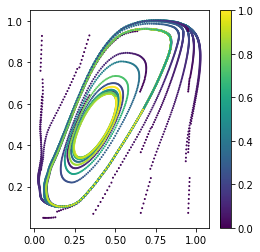

In [48]:
#test model starting from different parts of the state space (off the limit cycle)
train_window=10
y0 = torch.tensor(make_grid(state_size, .05, 1., .3)) #grid *same as before)
t_train_window = t[:train_window] #first train_window (10) time points
ys_tw = torchsde.sdeint(sde, y0, t_train_window)

fig = plt.figure(figsize=(4, 4), facecolor='white')
ax_traj = fig.add_subplot(111)
pred_len = 500
fromi = train_window + 40
# toi = 
cmap = plt.cm.viridis
for i in range(batch_size):
    ys_tw_i = ys_tw[:,i,:].squeeze().detach().numpy()
    # test_inputs = data_train_r[0].squeeze().detach().numpy()
    # pred_traj = model_predict(pred_len, model, test_inputs)
    pred_traj = model_predict(pred_len, model, ys_tw_i)
    # ax_traj.plot(pred_traj[fromi:,0], pred_traj[fromi:,1])
    # z = np.array([o for o in pred_traj])
    # z = np.reshape(z, [-1,2])
    # for i in range(len(z)):
        # sc = ax_traj.scatter(z[i:i+10, 0], z[i:i+10, 1], color=cmap(i/len(z)))
    sc = ax_traj.scatter(pred_traj[:,0], pred_traj[:, 1], s=1, color=cmap((t_len/pred_len)*t[:pred_len+train_window]/t[-1]))

plt.colorbar(sc)
plt.savefig(size_folder_name + "/fbehavior_grid_N%s.png"%hidden_size)

In [40]:
#use as data only limit cycle orbits
y_short = ys[time_shift:,:,:]
t_short = t[time_shift:]
# visualize_2d(y_short, times=t_short, xmin=0, xmax=1)

data_train_c, labels_c = create_batchio_sequences(y_short, train_window)

In [41]:
#learning with latent RNN
hidden_size = 100
learning_folder_name = folder_name+"/N%s/"%hidden_size+"/cyclelearning/"
makedirs(learning_folder_name)

feature_size = true_y.shape[2]
cycle_model = fcRNN(feature_size, hidden_size, feature_size, 2).to(device)

pytorch_total_params = sum(p.numel() for p in cycle_model.parameters())
print("Model has a total of {0} parameters.".format(pytorch_total_params))

Model has a total of 30802 parameters.


In [42]:
pred_len = y_short.shape[0]-train_window
epochs = 1000
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(cycle_model.parameters(), lr=1e-3)
ii = 0
for itr in tqdm(range(epochs)):
    # if itr > 2000:
    #     optimizer.param_groups[0]['lr'] = 1e-3
    optimizer.zero_grad()
    y_pred = cycle_model(data_train_c.to(device))
    loss = loss_function(y_pred.to(device), labels_c.squeeze().to(device))
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
    if itr % test_freq == 0:
        print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.8f}')
        test_inputs = data_train_c[0].squeeze().detach().numpy()
        pred_traj = model_predict(pred_len, cycle_model, test_inputs)
        save_name = learning_folder_name +"/learning_T%s"%itr
        visualize_2d(y_short, torch.tensor(pred_traj).unsqueeze(1), t_short, title="Training step %s"%itr, save=save_name, xmin=0., xmax=1.)
        plt.close()
        ii += 1

print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.10f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0 loss: 0.28725210
epoch:  50 loss: 0.01626954
epoch: 100 loss: 0.00500759
epoch: 150 loss: 0.00325412
epoch: 200 loss: 0.00003078
epoch: 250 loss: 0.00000853
epoch: 300 loss: 0.00000556
epoch: 350 loss: 0.00000413
epoch: 400 loss: 0.00000325
epoch: 450 loss: 0.00000261
epoch: 500 loss: 0.00000212
epoch: 550 loss: 0.00000175
epoch: 600 loss: 0.00005560
epoch: 650 loss: 0.00000127
epoch: 700 loss: 0.00000104
epoch: 750 loss: 0.00000089
epoch: 800 loss: 0.00000078
epoch: 850 loss: 0.00001078
epoch: 900 loss: 0.00000063
epoch: 950 loss: 0.00000054
epoch: 999 loss: 0.0000005016


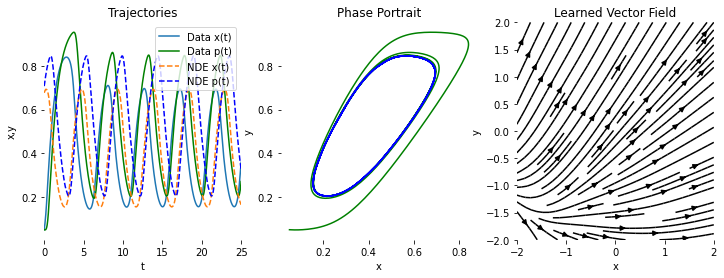

In [43]:
test_inputs = data_train_c[-1].squeeze().detach().numpy()
pred_traj = model_predict(t.shape[0]-train_window, cycle_model, test_inputs)
pred_y = torch.tensor(pred_traj).unsqueeze(1) #odeint(func, y0.to(device), t.to(device)).to(device)
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)

ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
# ax_traj.set_ylim(-2, 2)
ax_traj.legend(['Data x(t)', 'Data p(t)', 'NDE x(t)', 'NDE p(t)'])

ax_phase.cla()
ax_phase.set_title('Phase Portrait')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
# ax_phase.set_xlim(-2, 2)
# ax_phase.set_ylim(-2, 2)

ax_vecfield.cla()
ax_vecfield.set_title('Learned Vector Field')
ax_vecfield.set_xlabel('x')
ax_vecfield.set_ylabel('y')
y, x = np.mgrid[-2:2:21j, -2:2:21j]
dydt = model(torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 1, 2)).to(device)).cpu().detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = (dydt / mag)
dydt = dydt.reshape(21, 21, 2)

ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
# ax_vecfield.set_xlim(-2, 2)
# ax_vecfield.set_ylim(-2, 2)
plt.savefig(size_folder_name + "/cyclearn_behavior_N%s.png"%hidden_size)
plt.show()

In [44]:
#test model starting from different parts of the state space (off the limit cycle)
train_window=10
y0 = torch.tensor(make_grid(state_size, .05, 1., .3)) #grid *same as before)
t_train_window = t[:train_window] #first train_window (10) time points
ys_tw = torchsde.sdeint(sde, y0, t_train_window)

In [45]:
fig = plt.figure(figsize=(4, 4), facecolor='white')
ax_traj = fig.add_subplot(111)
pred_len = 500
fromi = train_window + 40
# toi = 
cmap = plt.cm.viridis
for i in range(batch_size):
    ys_tw_i = ys_tw[:,i,:].squeeze().detach().numpy()
    pred_traj = model_predict(pred_len, cycle_model, ys_tw_i)
    sc = ax_traj.scatter(pred_traj[:,0], pred_traj[:, 1], s=1, color=cmap((t_len/pred_len)*t[:pred_len+train_window]/t[-1]))

plt.colorbar(sc)
plt.savefig(size_folder_name + "/cyclebehavior_grid_N%s.png"%hidden_size)